<a href="https://colab.research.google.com/github/Shaurya016/Celebal-Assignment-06/blob/main/Assignment06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📁 STEP 1: Upload CSV files
from google.colab import files

# Upload train.csv, test.csv, sample_submission.csv
uploaded = files.upload()

Saving data.xlsx to data.xlsx


In [ ]:
# 1. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 2. Load the dataset (replace with your Colab path or mount)
df = pd.read_excel('/content/data.xlsx')  # Corrected file name and function
df.drop(['id'], axis=1, inplace=True)  # Drop unnecessary columns

In [ ]:
# 3. Encode the target
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [ ]:
# 4. Split into features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']


In [ ]:
# 5. Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 6. Train base models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

print("📊 Base Model Performance:\n")
print(pd.DataFrame(results).T)

📊 Base Model Performance:

                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.973684   0.976190  0.953488  0.964706
SVM                  0.982456   1.000000  0.953488  0.976190
Decision Tree        0.929825   0.906977  0.906977  0.906977
Random Forest        0.964912   0.975610  0.930233  0.952381
Naive Bayes          0.964912   0.975610  0.930233  0.952381


In [ ]:
# 7. Hyperparameter Tuning

# GridSearchCV for SVM
svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid_svm = GridSearchCV(SVC(), svm_params, cv=5, scoring='f1', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# RandomizedSearchCV for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}
random_rf = RandomizedSearchCV(RandomForestClassifier(), rf_params, n_iter=10, cv=5, scoring='f1', random_state=42, n_jobs=-1)
random_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='f1')

In [ ]:
# 8. Evaluate Tuned Models
tuned_models = {
    "Tuned SVM": grid_svm.best_estimator_,
    "Tuned Random Forest": random_rf.best_estimator_
}

for name, model in tuned_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }

In [ ]:
# 9. Final Comparison
print("\n🔍 Final Model Performance (Base + Tuned):\n")
final_df = pd.DataFrame(results).T.sort_values(by="F1 Score", ascending=False)
print(final_df)

# 10. Print Best Parameters
print("\n🛠️ Best SVM Params:", grid_svm.best_params_)
print("🛠️ Best RF Params:", random_rf.best_params_)


🔍 Final Model Performance (Base + Tuned):

                     Accuracy  Precision    Recall  F1 Score
SVM                  0.982456   1.000000  0.953488  0.976190
Tuned SVM            0.982456   1.000000  0.953488  0.976190
Logistic Regression  0.973684   0.976190  0.953488  0.964706
Naive Bayes          0.964912   0.975610  0.930233  0.952381
Random Forest        0.964912   0.975610  0.930233  0.952381
Tuned Random Forest  0.964912   0.975610  0.930233  0.952381
Decision Tree        0.929825   0.906977  0.906977  0.906977

🛠️ Best SVM Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
🛠️ Best RF Params: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 5}


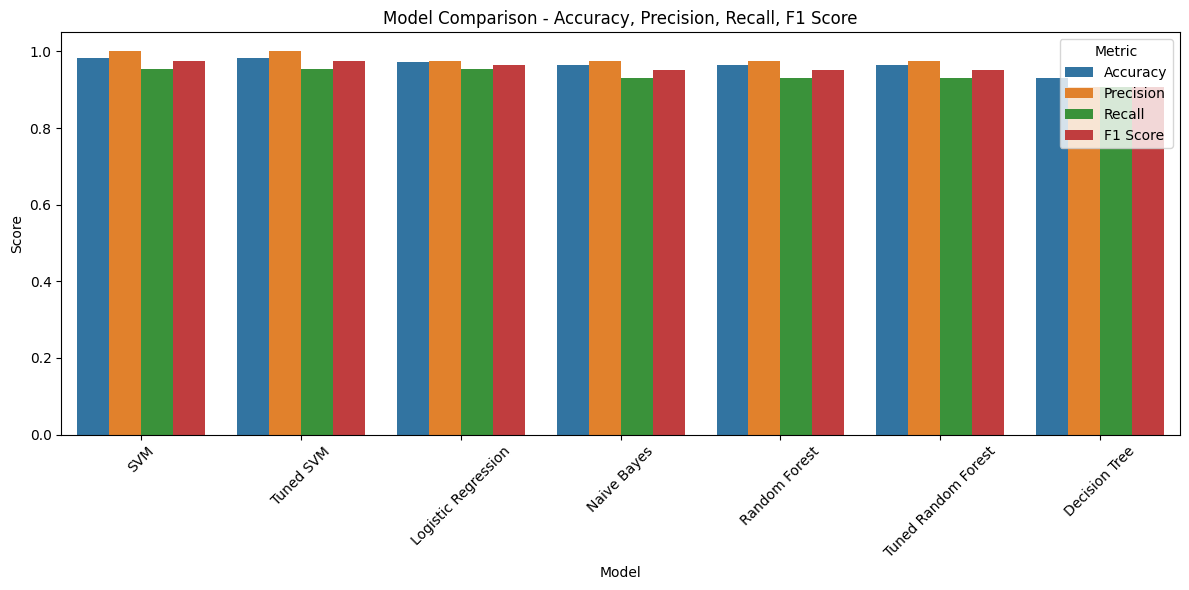

In [ ]:
# Plotting model comparison
metric_df = pd.DataFrame(results).T.sort_values(by="F1 Score", ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=metric_df.reset_index().melt(id_vars='index'), x='index', y='value', hue='variable')
plt.title("Model Comparison - Accuracy, Precision, Recall, F1 Score")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

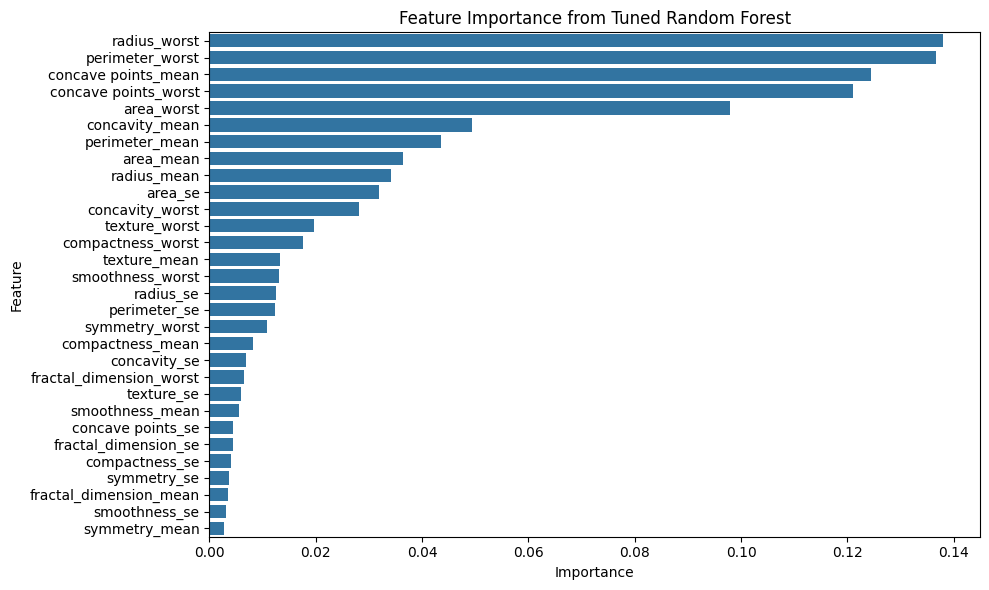

In [ ]:
# Feature Importance from Tuned Random Forest
importances = random_rf.best_estimator_.feature_importances_
features = X.columns
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature')
plt.title("Feature Importance from Tuned Random Forest")
plt.tight_layout()
plt.show()


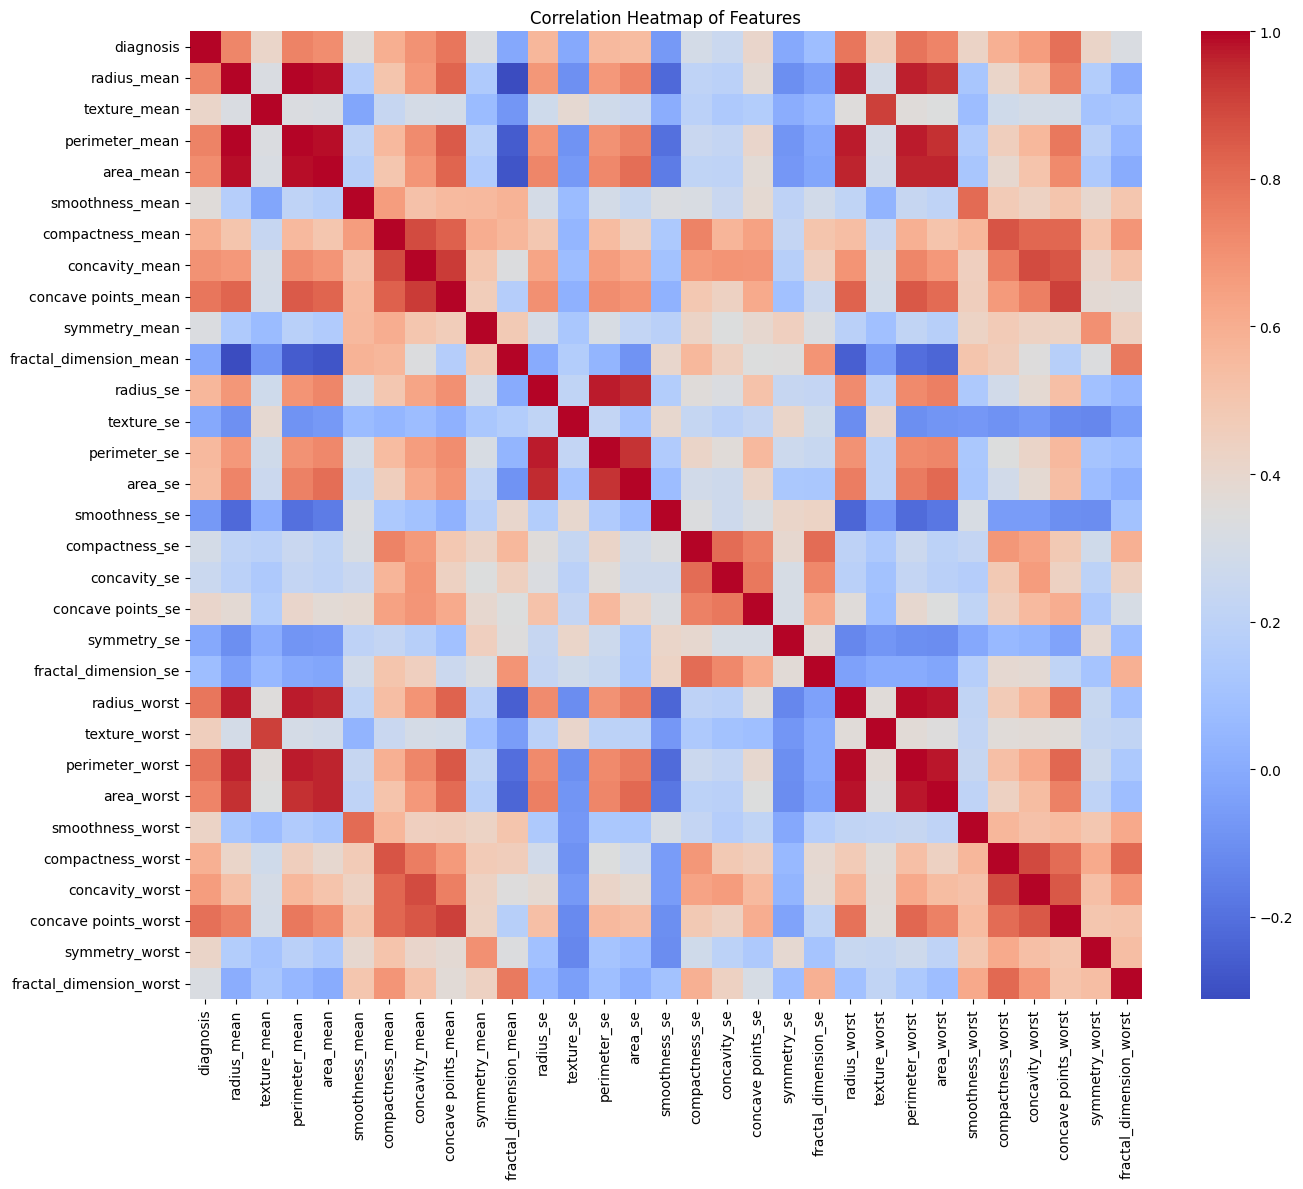

In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()


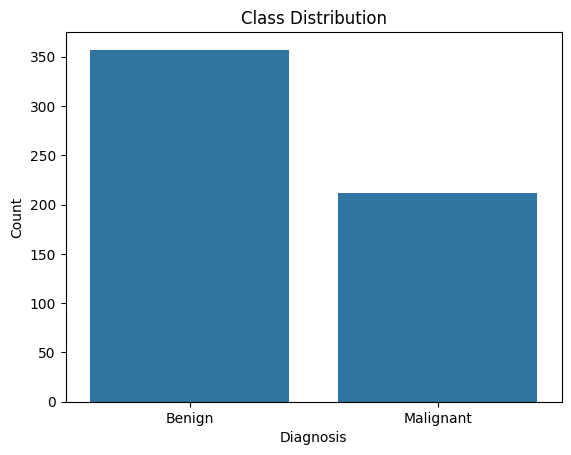

In [ ]:
sns.countplot(x='diagnosis', data=df)
plt.title("Class Distribution")
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.ylabel("Count")
plt.xlabel("Diagnosis")
plt.show()


/tmp/ipython-input-18-3885041650.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')


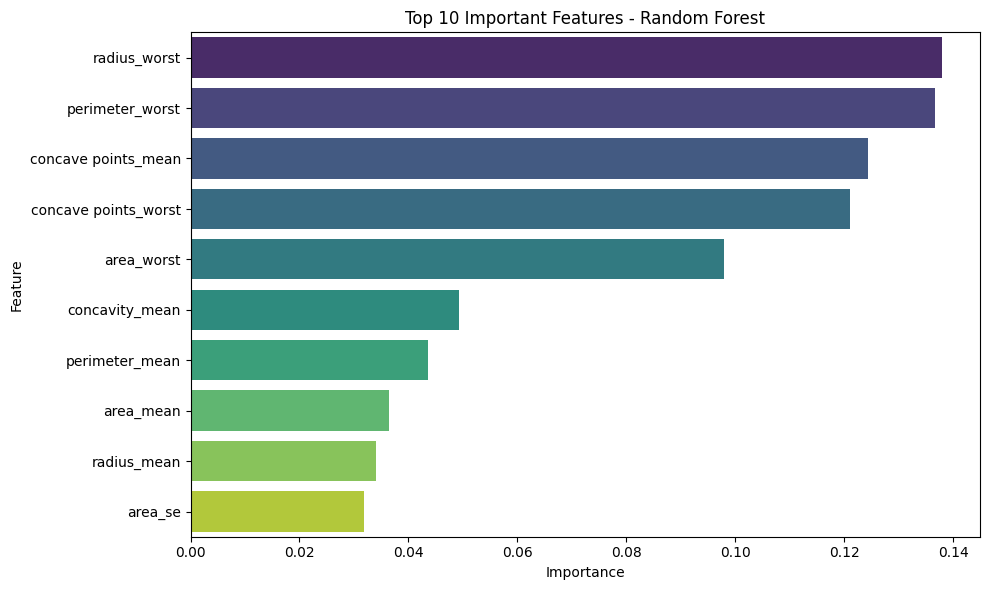

In [ ]:
feat_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': random_rf.best_estimator_.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Important Features - Random Forest")
plt.tight_layout()
plt.show()


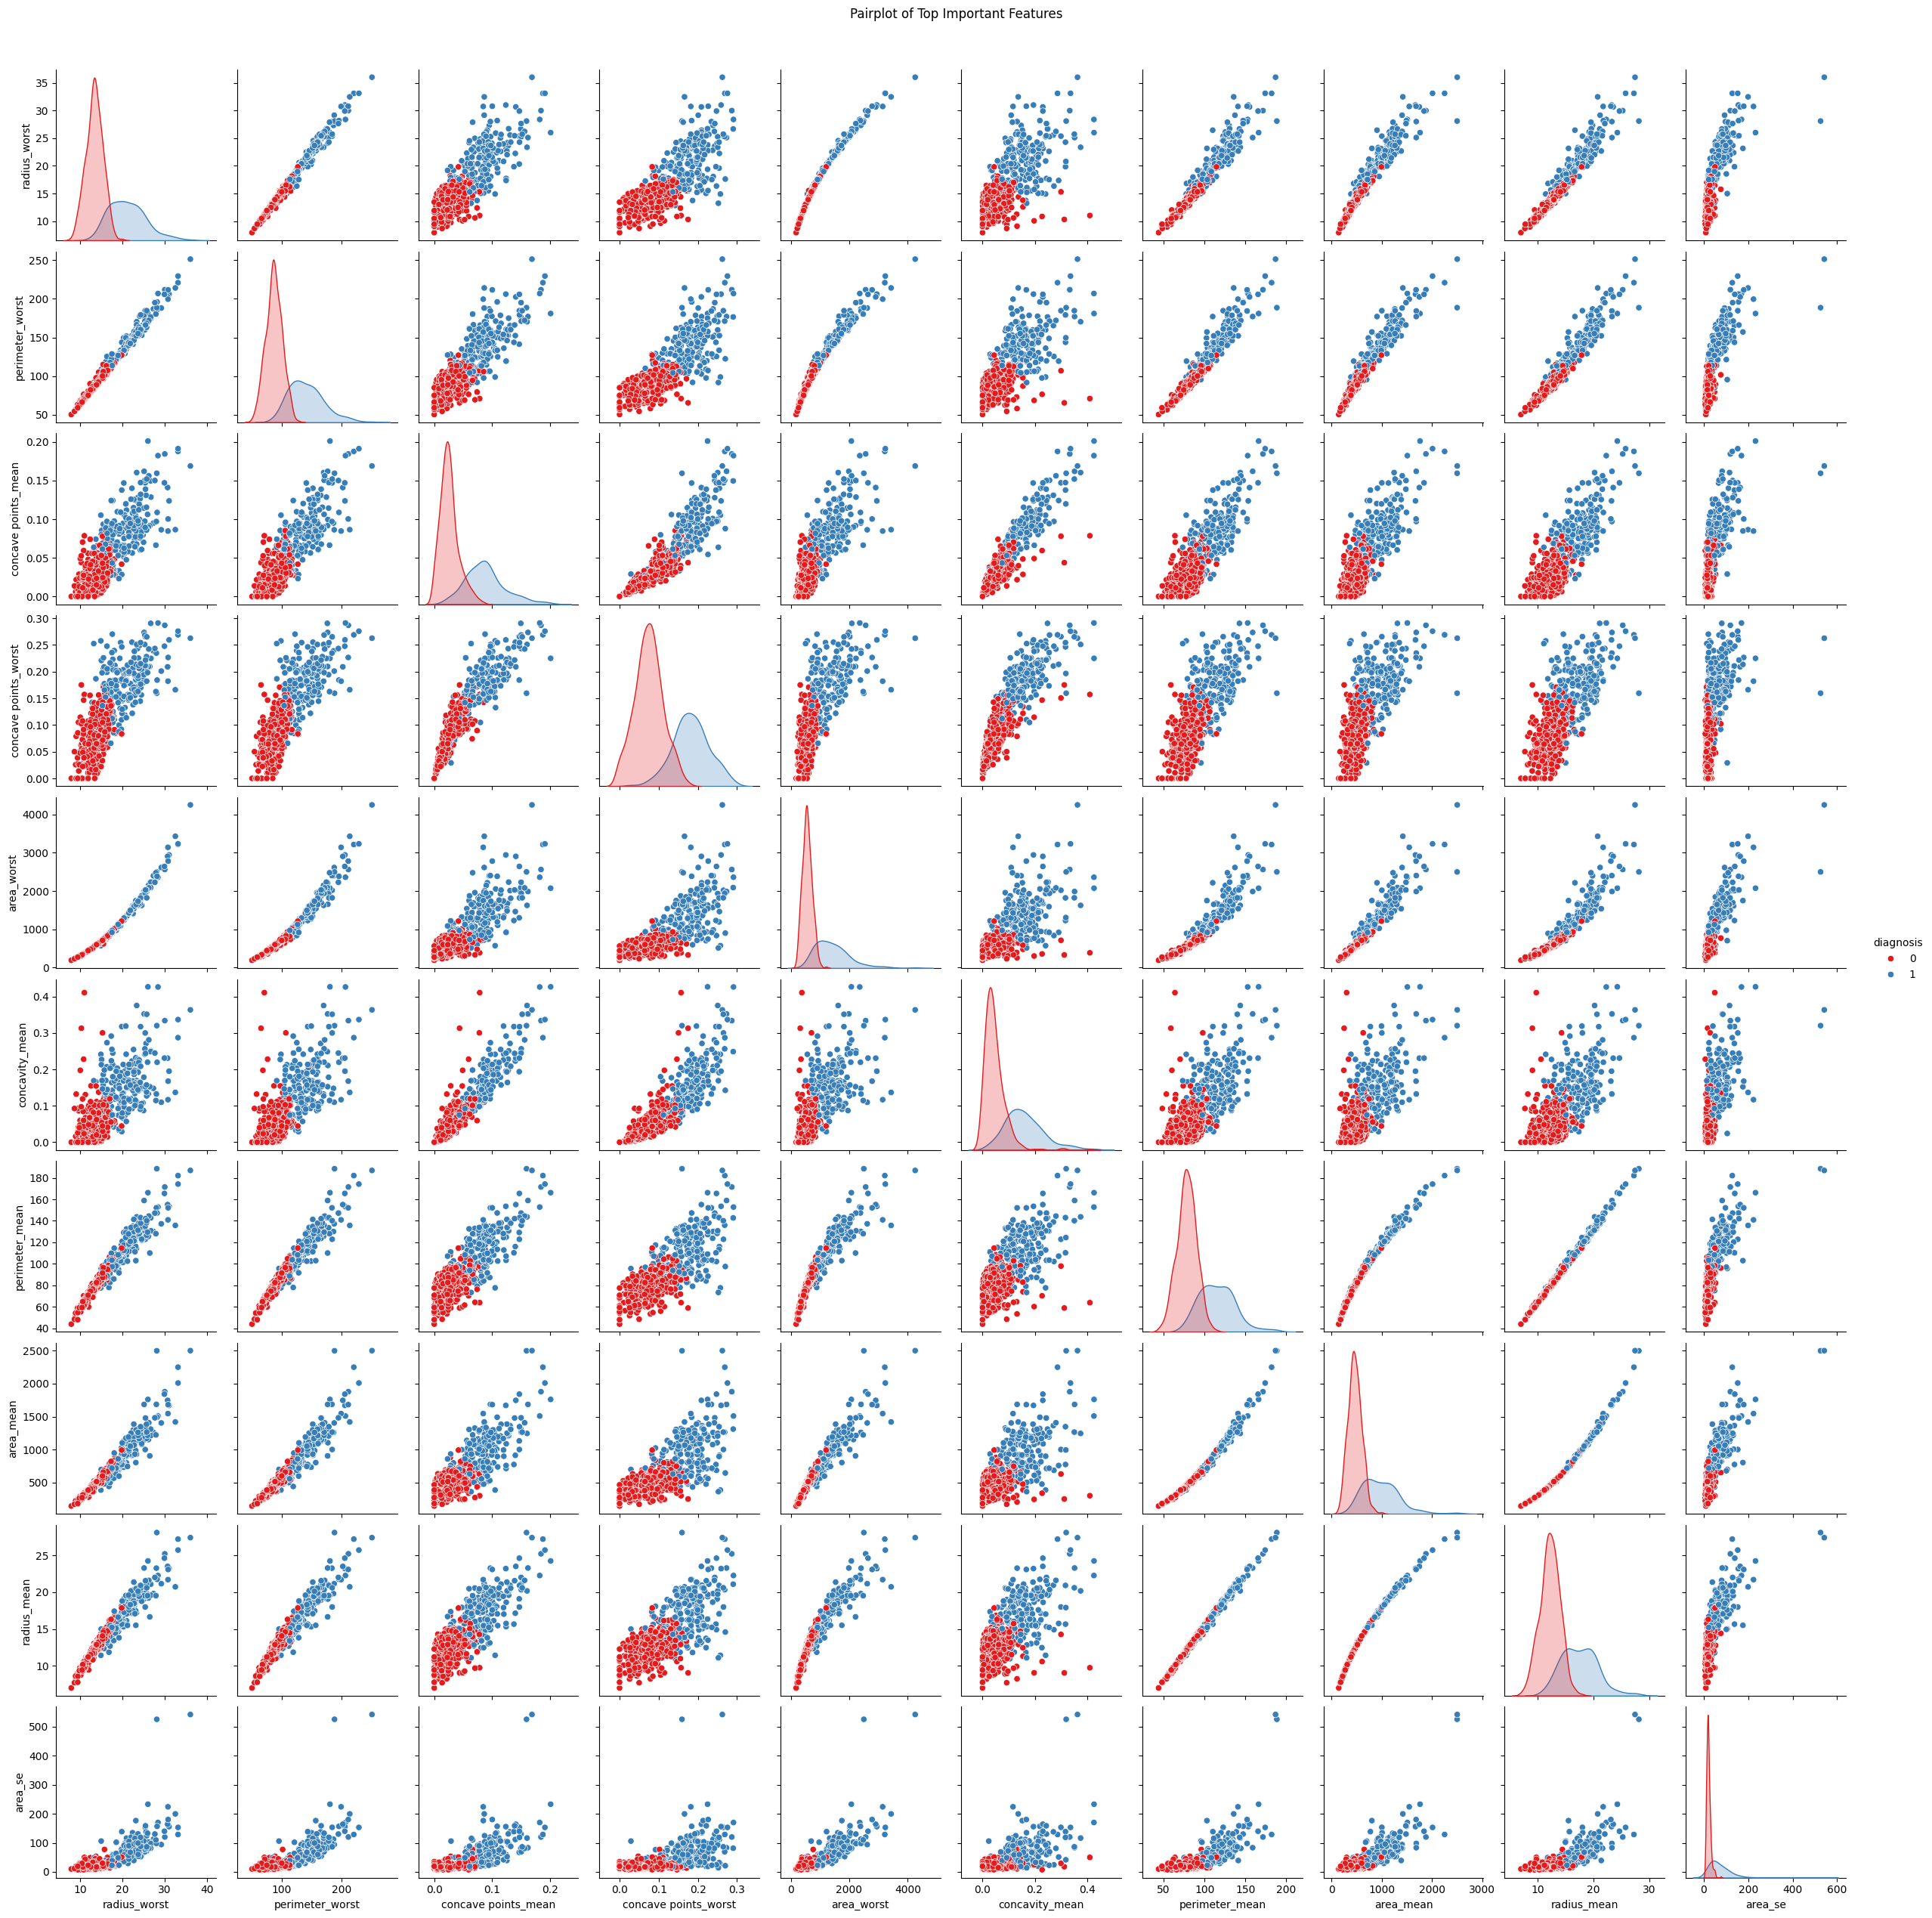

In [ ]:
top_feats = feat_df['Feature'].tolist()
sns.pairplot(df[top_feats + ['diagnosis']], hue='diagnosis', palette='Set1')
plt.suptitle("Pairplot of Top Important Features", y=1.02)
plt.show()


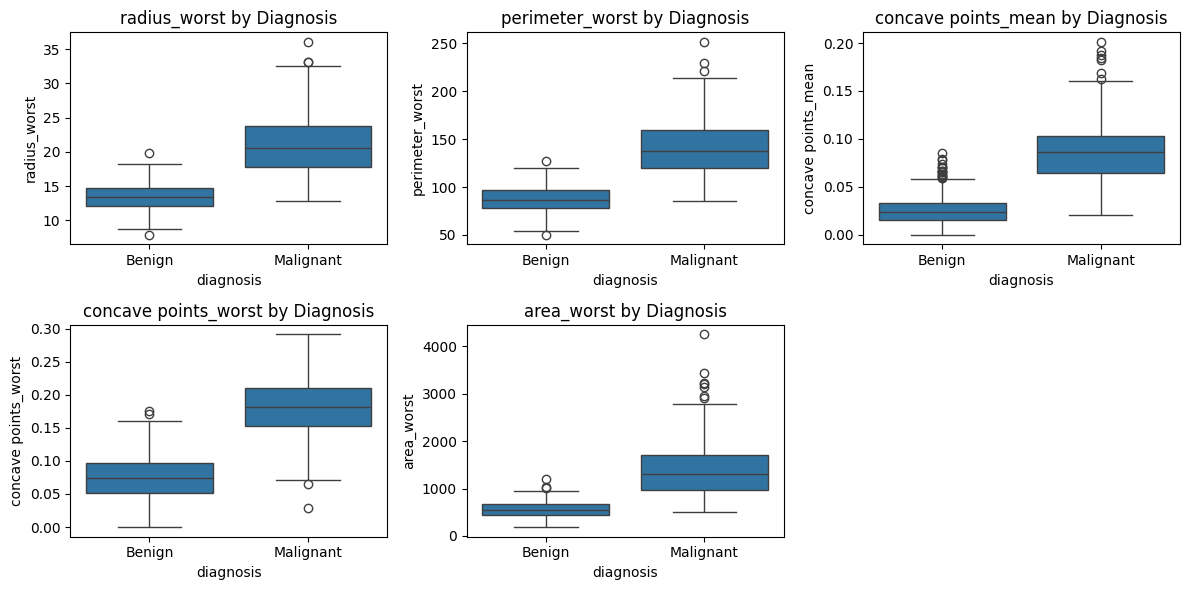

In [ ]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(top_feats[:5]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='diagnosis', y=feature, data=df)
    plt.title(f"{feature} by Diagnosis")
    plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.tight_layout()
plt.show()


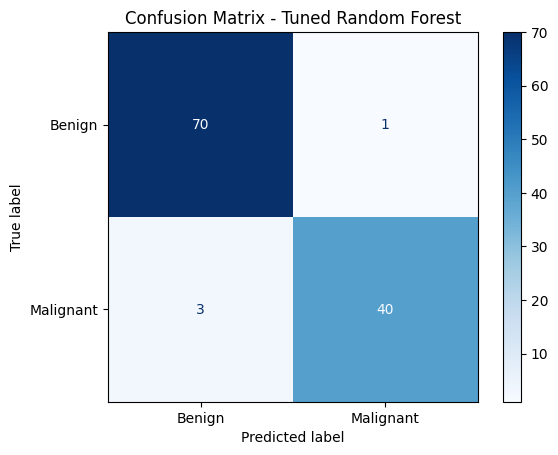

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(random_rf.best_estimator_, X_test, y_test, display_labels=["Benign", "Malignant"], cmap="Blues")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.show()
